In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, kornia_rotation

In [2]:
### --- Config --- ###
# dataset
target_rotation_deg = 90.

# training
init_rotation_deg = 60.
batch_size = 64
epochs = 1
lr=0.1
# momentum=0.9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.RandomAffine(degrees=[target_rotation_deg,target_rotation_deg], p=1), # nn.Module
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

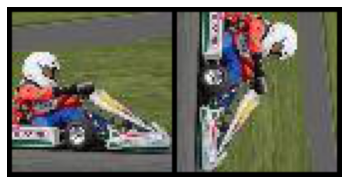

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
class AugmentationNetwork(nn.Module):
    def __init__(self, init_rot_degree):
        super().__init__()
        self.trans_param = Parameter(torch.Tensor([init_rot_degree]),
                                     requires_grad=True)

    def forward(self, x):
        rand_rotation = K.augmentation.RandomRotation(
                        torch.cat([self.trans_param, self.trans_param]), p=1) # torch cat prevernts parameter from casting to float.
        out = rand_rotation(x)
        return out

In [8]:
model = AugmentationNetwork(init_rot_degree=init_rotation_deg)
model.to(device)

AugmentationNetwork()

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

trans_param tensor([60.], device='cuda:0')


In [10]:
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
losses = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | {model.trans_param.item()}]')
            running_loss = 0.0
        
        if i == 300:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.135 | 60.96733093261719]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.135 | 61.92814636230469]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.138 | 62.9124755859375]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.135 | 63.86852264404297]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.126 | 64.99085235595703]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.134 | 66.06629180908203]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.133 | 67.18780517578125]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.135 | 68.33243560791016]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.135 | 69.4793472290039]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.136 | 70.6544189453125]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.131 | 71.8804931640625]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.130 | 73.11067962646484]
[Epoch: 1 | Batch: 130 | MSE Loss: 0.131 | 74.34669494628906]
[Epoch: 1 | Batch: 140 | MSE Loss: 0.127 | 75.6357650756836]
[Epoch: 1 | Batch: 150 | MSE Loss: 0.128 | 76.96086120605469]
[Epoch: 1 | Batch: 160 | MSE Loss: 0.126 | 78.33214569091797]
[Epoch: 1 | Batch: 170

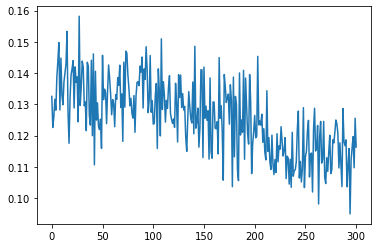

In [12]:
plt.plot(losses)